# LSTM Model Performance Evolution

The results obtained from the model gives us whether the devices in the MTD network will transmit or not during the future timesteps. In other words, after normalize and round up final LSTM of output values takes finery form. 

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras import optimizers

Using TensorFlow backend.


## Load MTD Transmission Data

In [2]:
train_1 = np.load('5_mtd_train_restruct.npz')['dat_tr']
train_2 = np.load('5_mtd_train_restruct.npz')['lbl_tr']
test_1= np.load('5_mtd_test_restruct.npz')['dat_ts']
test_2 = np.load('5_mtd_test_restruct.npz')['lbl_ts']

## Train Optimal LSTM Model

In [3]:
regressor = Sequential()

regressor.add(LSTM(units = 100, input_shape = (train_1.shape[1], 5)))
regressor.add(Dropout(0.25))

# Adding the output layer
regressor.add(Dense(units = 5))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['binary_accuracy'])

# Fitting the RNN to the Training set
history1 = regressor.fit(train_1, train_2, batch_size = 120, validation_data=(test_1, test_2), epochs = 26)

score = regressor.evaluate(test_1, test_2)

print('Validation loss    :', score[0])
print('Validation accuracy:', score[1])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 9588 samples, validate on 2388 samples
Epoch 1/26
9588/9588 [==============================] - 2s 211us/step - loss: 0.2341 - binary_accuracy: 0.6194 - val_loss: 0.1991 - val_binary_accuracy: 0.6687
Epoch 2/26
9588/9588 [==============================] - 2s 166us/step - loss: 0.1813 - binary_accuracy: 0.7074 - val_loss: 0.1545 - val_binary_accuracy: 0.7499
Epoch 3/26
9588/9588 [==============================] - 2s 165us/step - loss: 0.1513 - binary_accuracy: 0.7576 - val_loss: 0.1320 - val_binary_accuracy: 0.7861
Epoch 4/26
9588/9588 [==============================] - 2s 165us/step - loss: 0.1362 - binary_accuracy: 0.7856 - val_loss: 0.1217 - val_binary_accuracy: 0.8161
Epoch 5/26
9588/9588 [==============================] - 2s 165us/step - loss: 0.1290 - binary_accuracy: 0.7992 - val_loss: 0.1181 - val_binary_accuracy: 0.8208
Epoch 6/26
9588/9588 [==============================] - 2s 165us/step 

## Model Testing

In [4]:
predicted = regressor.predict(test_1)
loss, accuracy=regressor.evaluate(test_1, test_2)
print("accucary: " + str(accuracy) + "\n" + "loss: " +  str(loss))

2388/2388 [==============================] - 0s 62us/step
accucary: 0.8309882879257202
loss: 0.10382800907445713


## Normalizing LSTM output values

In [5]:
normalized = (predicted-np.min(predicted))/(np.max(predicted)-np.min(predicted))

## Rounding up normalized LSTM output values

In [6]:
predict = np.round(normalized)

## Define model performance evaluation function

In [7]:
def accuracy(predicted, actual):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for idx, value in np.ndenumerate(predicted):
        if predicted[idx] == 1 and actual[idx] == 1:
            TP+=1
        elif predicted[idx] == 1 and actual[idx] == 0:
            FP+=1
        elif predicted[idx] == 0 and actual[idx] == 1:
            FN+=1
        elif predicted[idx] == 0 and actual[idx] == 0:
            TN+=1
            
    precision= (TP / (TP + FP))*100
    sensitivity = (TP / (TP + FN))*100
    specificity = (TN / (FP + TN) )*100   
    fscore = (2*TP /(2*TP + FP + FN)  )*100
    accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
    return [[TP],[FP],[FN],[TN],[precision],[sensitivity],[specificity],[fscore],[accuracy]]

## Apply model revelation function on LSTM output

In [8]:
model_evaluation = []
# MTD wise performace evaluation
for i in range(0,5):
    MTDi = accuracy(predict[:,i],test_2[:,i])
    model_evaluation.append(MTDi)
# over all performace evaluation
MTDi = accuracy(predict,test_2)
model_evaluation.append(MTDi)

In [9]:
## Create dataframe contain model evaltuon parameter values

In [10]:
model_evaluation_array = np.array(model_evaluation)
columns = ["TP", "FP", "FN", "TN", "precision","sensitivity","specificity","fscore","accuracy"]
rows= ["MTD X", "MTD Y", "MTD Z", "MTD T","MTD W", "Overall"]
model_evaluation_pd = pd.DataFrame(model_evaluation_array[:,:,0],columns = columns)
model_evaluation_pd = model_evaluation_pd.set_index(pd.Index(rows))
model_evaluation_pd

,TP,FP,FN,TN,precision,sensitivity,specificity,fscore,accuracy
MTD X,1017.0,110.0,53.0,1208.0,90.239574,95.046729,91.654021,92.580792,93.174204
MTD Y,1158.0,1177.0,28.0,25.0,49.593148,97.639123,2.079867,65.776768,49.539363
MTD Z,752.0,318.0,0.0,1318.0,70.280374,100.000000,80.562347,82.546652,86.683417
MTD T,839.0,348.0,0.0,1201.0,70.682393,100.000000,77.533893,82.823297,85.427136
MTD W,839.0,0.0,0.0,1549.0,100.000000,100.000000,100.000000,100.000000,100.000000
Overall,4605.0,1953.0,81.0,5301.0,70.219579,98.271447,73.076923,81.910352,82.964824


Therefore, LSTMs can be viewed as a promising approach for predicting source trafﬁc prediction in a Fast Uplink Grant environment. Furthermore, apart from the better metrics such as accuracy, LSTMs have an added advantage in scalability. They have the capability to handle any number of sequences from each MTD, essentially when IoT networks grow in size.

In [11]:
def accuracy(predicted, actual):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for idx, value in np.ndenumerate(predicted):
        if predicted[idx] == 1 and actual[idx] == 1:
            TP+=1
        elif predicted[idx] == 1 and actual[idx] == 0:
            FP+=1
        elif predicted[idx] == 0 and actual[idx] == 1:
            FN+=1
        elif predicted[idx] == 0 and actual[idx] == 0:
            TN+=1
                
    sensitivity = (TP / (TP + FN))*100
    FDR = (FP / (TP + FP))*100
    accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
    return [[TP], [FP], [FN], [TN], [sensitivity], [FDR] ,[accuracy]]

In [12]:
model_evaluation = []
# MTD wise performace evaluation
for i in range(0,5):
    MTDi = accuracy(predict[:,i],test_2[:,i])
    model_evaluation.append(MTDi)
# over all performace evaluation
MTDi = accuracy(predict,test_2)
model_evaluation.append(MTDi)

In [13]:
model_evaluation_array = np.array(model_evaluation)
columns = ["TP", "FP", "FN", "TN", "Reduction of RA requests (sensitivity) ","Resource wastage (False discovery rate - FDR)","Accuracy"]
rows= ["MTD X", "MTD Y", "MTD Z", "MTD T","MTD W", "Overall"]
model_evaluation_pd = pd.DataFrame(model_evaluation_array[:,:,0],columns = columns)
model_evaluation_pd = model_evaluation_pd.set_index(pd.Index(rows))
model_evaluation_pd

,TP,FP,FN,TN,Reduction of RA requests (sensitivity),Resource wastage (False discovery rate - FDR),Accuracy
MTD X,1017.0,110.0,53.0,1208.0,95.046729,9.760426,93.174204
MTD Y,1158.0,1177.0,28.0,25.0,97.639123,50.406852,49.539363
MTD Z,752.0,318.0,0.0,1318.0,100.000000,29.719626,86.683417
MTD T,839.0,348.0,0.0,1201.0,100.000000,29.317607,85.427136
MTD W,839.0,0.0,0.0,1549.0,100.000000,0.000000,100.000000
Overall,4605.0,1953.0,81.0,5301.0,98.271447,29.780421,82.964824


In [14]:
model_evaluation_pd.iloc[0:5:1,3].values

array([1208.,   25., 1318., 1201., 1549.])

In [20]:
# number of columns
NC = 3
barWidth = 1/(NC+1)
row = []
for x in range(0,NC):
    r = float(x)/(NC+1)
    row.append(r)
row = np.array(row)

# number of rows
NR = 6
Rows = []
for x in range(0,NR):
    row_1 = []
    Rows.append(row+x)
Rows = np.array(Rows)
# getting the transpose
Rows = np.transpose(Rows)

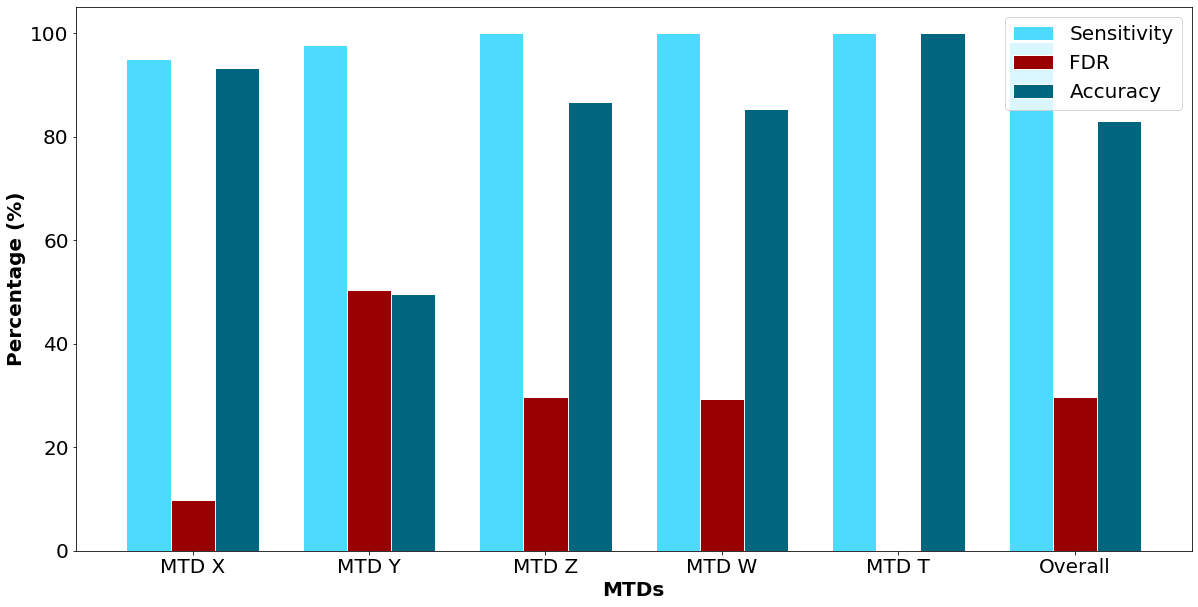

In [21]:
# Make the plot
plt.bar(Rows[0], model_evaluation_pd.iloc[:,4].values, color='#4cdbff', width=barWidth, edgecolor='white', label='Sensitivity')
plt.bar(Rows[1], model_evaluation_pd.iloc[:,5].values, color='#990000', width=barWidth, edgecolor='white', label='FDR')
plt.bar(Rows[2], model_evaluation_pd.iloc[:,6].values, color='#00667f', width=barWidth, edgecolor='white', label='Accuracy')
 
# Add xticks on the middle of the group bars
plt.xlabel('MTDs', fontweight='bold')
plt.ylabel('Percentage (%)', fontweight='bold')
plt.xticks([r + barWidth for r in range(NR)], ['MTD X', 'MTD Y', 'MTD Z', 'MTD W', 'MTD T', 'Overall'])
 
# Create legend & Show graphic
plt.rcParams['figure.figsize']=(20,10)
font ={'size':20}
plt.rc('font',**font)
plt.legend()
plt.show()

In [17]:
# number of columns
NC = 4
barWidth = 1/(NC+1)
row = []
for x in range(0,NC):
    r = float(x)/(NC+1)
    row.append(r)
row = np.array(row)

# number of rows
NR = 5
Rows = []
for x in range(0,NR):
    row_1 = []
    Rows.append(row+x)
Rows = np.array(Rows)
# getting the transpose
Rows = np.transpose(Rows)

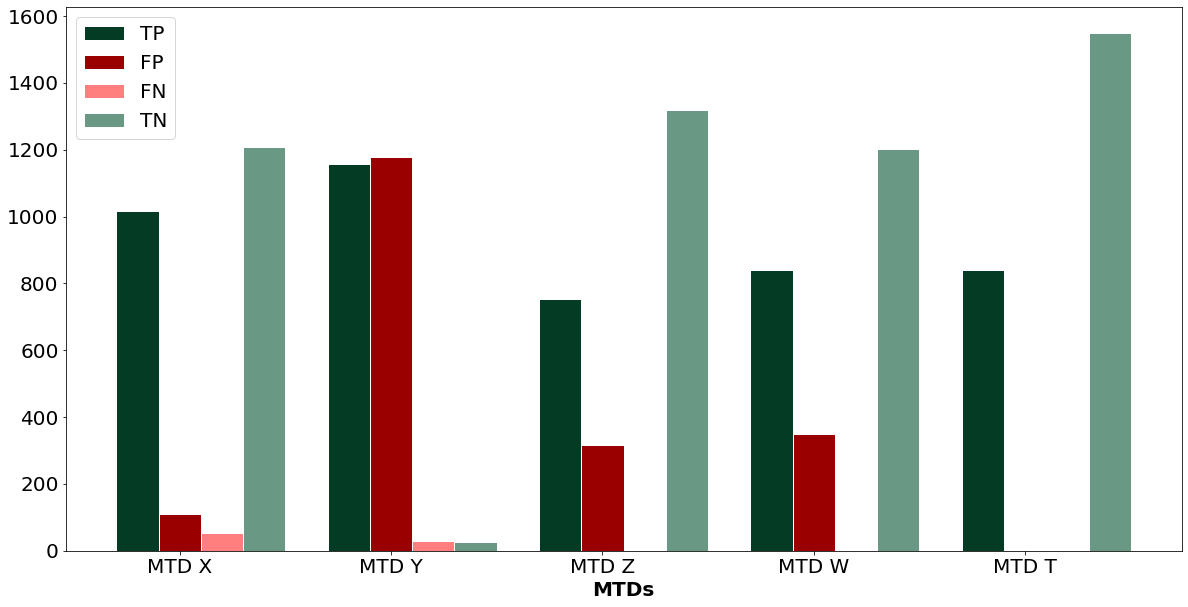

In [18]:
# Make the plot
plt.bar(Rows[0], model_evaluation_pd.iloc[0:5:1,0].values, color='#043b25', width=barWidth, edgecolor='white', label='TP')
plt.bar(Rows[1], model_evaluation_pd.iloc[0:5:1,1].values, color='#990000', width=barWidth, edgecolor='white', label='FP')
plt.bar(Rows[2], model_evaluation_pd.iloc[0:5:1,2].values, color='#ff7f7f', width=barWidth, edgecolor='white', label='FN')
plt.bar(Rows[3], model_evaluation_pd.iloc[0:5:1,3].values, color='#699985', width=barWidth, edgecolor='white', label='TN')
 
# Add xticks on the middle of the group bars
plt.xlabel('MTDs', fontweight='bold')
plt.xticks([r + barWidth for r in range(NR)], ['MTD X', 'MTD Y', 'MTD Z', 'MTD W', 'MTD T', 'Overall'])
 
# Create legend & Show graphic
plt.rcParams['figure.figsize']=(20,10)
font ={'size':20}
plt.rc('font',**font)
plt.legend()
plt.show()